<a href="https://colab.research.google.com/github/nebulous05/influence-functions-pytorch/blob/main/attempt6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Subset
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import random
import copy

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ],
    )
full_train_set = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_set = datasets.MNIST("./data", train=False, download=True, transform=transform)
train_set, val_set = random_split(full_train_set, [55000, 5000])

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:01<00:00, 5563326.33it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 161869.08it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1315869.70it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 6614766.93it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1400, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1000, shuffle=False)

In [4]:
# some functions to retrieve/view data
def get_item(index, dataset='train'):
    ''' returns a pair (image_tensor, label_int) '''
    if dataset == 'train':
        return train_set[index]
    elif dataset == 'test':
        return test_set[index]

def show_image(index, dataset='train'):
    ''' show an image with matplotlib '''
    if dataset == 'train':
        img = train_set[index][0].numpy().reshape(28, 28)
    elif dataset == 'test':
        img = test_set[index][0].numpy().reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.show()

In [5]:
class LogReg(nn.Module):
    def __init__(self):
        super(LogReg, self).__init__()
        self.linear = nn.Linear(784, 10, bias=False)

    def forward(self, x):
        x = x.view(-1, 784)
        return self.linear(x)

In [6]:
def train_until_convergence(model, train_dataloader, val_dataloader, loss_fn,
                            optimizer, threshold=0.001, max_epochs=100):
  torch.manual_seed(42)
  random.seed(42)
  np.random.seed(42)

  train_losses = []
  val_accuracies = []

  prev_epoch_loss = float('inf')
  patience = 0

  for epoch in range(max_epochs):
    model.train()
    # train_dataloader epoch
    current_epoch_loss = 0.0
    for data, target in train_dataloader:
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      current_epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
    train_losses.append(current_epoch_loss / len(train_dataloader))
    print(f"Epoch {epoch+1}/{max_epochs}, Loss: {current_epoch_loss / len(train_dataloader)}")

    # val_dataloader accuracy compute
    with torch.no_grad():
      model.eval()
      correct = 0
      for data, target in val_dataloader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
      val_accuracy = correct / len(val_dataloader.dataset)
      val_accuracies.append(val_accuracy)

    # early stopping
    if abs((prev_epoch_loss - current_epoch_loss) / len(train_dataloader)) < threshold:
      patience += 1
    else:
      patience = 0
    prev_epoch_loss = current_epoch_loss/len(train_dataloader)
    if patience == 5:
      break

  return train_losses, val_accuracies

In [7]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)
model = LogReg()
# loss_fn = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
# torch.save(model.state_dict(), 'init_model_weights.pth')
model.load_state_dict(torch.load('model_weights.pth'))

<ipython-input-7-2307a2d1c9f5>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))


<All keys matched successfully>

In [ ]:
# train_losses, val_accuracies = train_until_convergence(model, train_loader, val_loader, loss_fn, optimizer)

Epoch 1/100, Loss: 1.3165099531412126
Epoch 2/100, Loss: 0.7388188287615776
Epoch 3/100, Loss: 0.6017748326063156
Epoch 4/100, Loss: 0.5364739418029785
Epoch 5/100, Loss: 0.4970370687544346
Epoch 6/100, Loss: 0.4701253406703472
Epoch 7/100, Loss: 0.450332722812891
Epoch 8/100, Loss: 0.4350191541016102
Epoch 9/100, Loss: 0.4227294221520424
Epoch 10/100, Loss: 0.4125898130238056
Epoch 11/100, Loss: 0.40404127165675163
Epoch 12/100, Loss: 0.39670800119638444
Epoch 13/100, Loss: 0.3903271645307541
Epoch 14/100, Loss: 0.38470892533659934
Epoch 15/100, Loss: 0.3797124266624451
Epoch 16/100, Loss: 0.37523065954446794
Epoch 17/100, Loss: 0.37118079960346223
Epoch 18/100, Loss: 0.3674975909292698
Epoch 19/100, Loss: 0.3641288407146931
Epoch 20/100, Loss: 0.3610322065651417
Epoch 21/100, Loss: 0.3581730335950851
Epoch 22/100, Loss: 0.3555225238204002
Epoch 23/100, Loss: 0.353056600689888
Epoch 24/100, Loss: 0.3507549397647381
Epoch 25/100, Loss: 0.3486002363264561
Epoch 26/100, Loss: 0.346577654

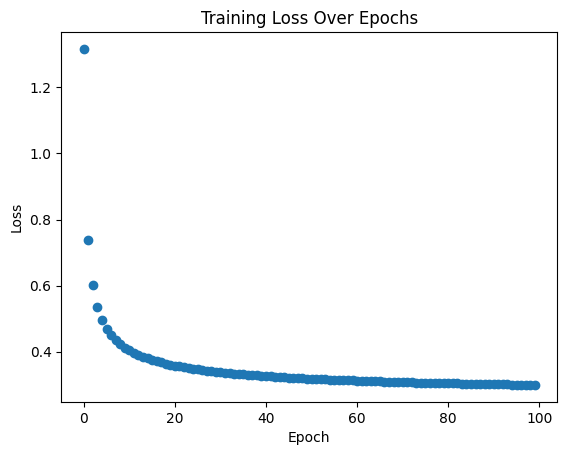

In [ ]:
plt.scatter(range(len(train_losses)), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

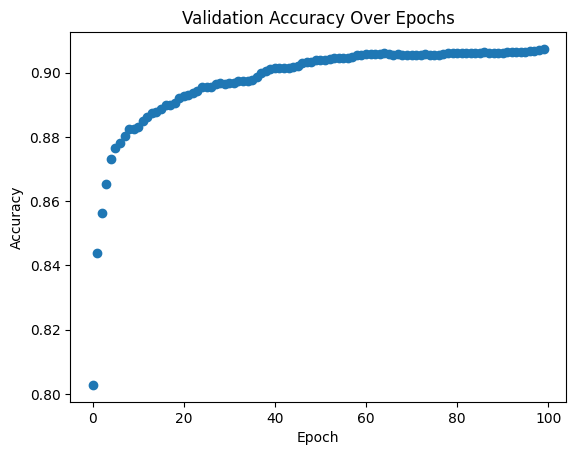

In [ ]:
plt.scatter(range(len(val_accuracies)), val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Over Epochs')
plt.show()

In [ ]:
torch.save(model.state_dict(), 'model_weights.pth')

In [8]:
wrongly_classified_indices = []

model.eval()
num_correct = 0
for i in range(len(test_set)):
    input, label = test_set[i]
    output = model(input)
    if torch.argmax(output) != label:
        wrongly_classified_indices.append(i)
    else:
      num_correct += 1
print("Test set accuracy: " + str(num_correct / len(test_set)) + " (" + str(num_correct) + "/" + str(len(test_set)) + ")")

Test set accuracy: 0.9185 (9185/10000)


z_label: 7
prediction: tensor(2)


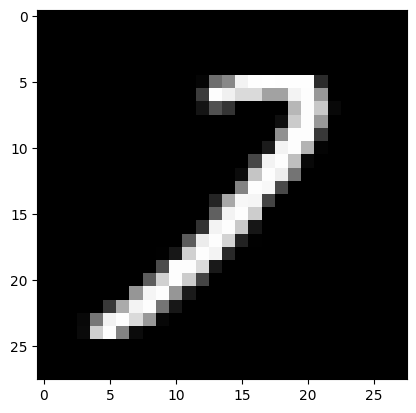

In [9]:
random.seed(42)
model.eval()
z_idx = wrongly_classified_indices[random.randint(0, len(wrongly_classified_indices)-1)]
z_input, z_label = test_set[z_idx]
prediction = torch.argmax(model(z_input))
print("z_label: " + str(z_label))
print("prediction: " + str(prediction))
show_image(z_idx, dataset='test')

In [53]:
def compute_gradient(my_model, input, label):
    ''' returns a Tensor representing the gradient of the loss
        wrt the model parameters (7840)'''
    my_model.eval()
    my_model.zero_grad()
    output = my_model(input)
    loss_fn = nn.CrossEntropyLoss()
    loss = loss_fn(output, torch.tensor([label], dtype=torch.long))
    grad_vector = torch.autograd.grad(loss, my_model.parameters(), create_graph=True)
    return grad_vector[0].view(-1)

def compute_hvp(my_model, input, label, v):
    my_model.eval()
    my_model.zero_grad()
    grad = compute_gradient(my_model, input, label)
    grad_v_product = torch.dot(grad, v)
    hvp = torch.autograd.grad(grad_v_product, my_model.parameters(), retain_graph=True)
    return hvp[0].view(-1)

def compute_s_test(my_model, training_set, z_input, z_label, recursion_depth=5000,
                   num_repeats=10, scale=50, damp=0.02):
    my_model.eval()
    v = compute_gradient(model, z_input, z_label) # shape==[7840]
    s_test = None

    for i in range(num_repeats):
        print("Repeat " + str(i))
        cur_estimate = v.clone()
        for j in range(recursion_depth):
            train_idx = random.randint(0, len(training_set)-1)
            input, label = training_set[train_idx]

            hvp = compute_hvp(my_model, input, label, cur_estimate)
            hvp = hvp.detach()

            cur_estimate = v + (1 - damp) * cur_estimate - hvp / scale

            cur_estimate = cur_estimate.detach()

            if j % 1000 == 0:
              print("Iteration " + str(j))
              print("Norm of cur_estimate: " + str(torch.norm(cur_estimate)))

        if s_test is None:
            s_test = cur_estimate / scale
        else:
            s_test += (cur_estimate / scale)

    return s_test * 0.7294# / num_repeats

In [54]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
s_test = compute_s_test(model, train_set, z_input, z_label)

Repeat 0
Iteration 0
Norm of cur_estimate: tensor(54.6043)
Iteration 1000
Norm of cur_estimate: tensor(1324.7617)
Iteration 2000
Norm of cur_estimate: tensor(1810.0227)
Iteration 3000
Norm of cur_estimate: tensor(1240.0260)
Iteration 4000
Norm of cur_estimate: tensor(1641.5724)
Repeat 1
Iteration 0
Norm of cur_estimate: tensor(54.3630)
Iteration 1000
Norm of cur_estimate: tensor(1400.3760)
Iteration 2000
Norm of cur_estimate: tensor(1263.9735)
Iteration 3000
Norm of cur_estimate: tensor(1244.3270)
Iteration 4000
Norm of cur_estimate: tensor(1285.3087)
Repeat 2
Iteration 0
Norm of cur_estimate: tensor(53.9822)
Iteration 1000
Norm of cur_estimate: tensor(1227.9980)
Iteration 2000
Norm of cur_estimate: tensor(1231.3608)
Iteration 3000
Norm of cur_estimate: tensor(1251.7728)
Iteration 4000
Norm of cur_estimate: tensor(1688.9454)
Repeat 3
Iteration 0
Norm of cur_estimate: tensor(54.6283)
Iteration 1000
Norm of cur_estimate: tensor(1462.7432)
Iteration 2000
Norm of cur_estimate: tensor(1658.

In [55]:
def compute_influence(my_model, training_set, s_test):
    my_model.eval()
    influence_scores = {}
    for i in range(len(training_set)):
        input, label = training_set[i]
        grads = compute_gradient(model, input, label)
        influence_scores[i] = -1 * (torch.dot(grads, s_test).item())
    return influence_scores

influence_scores = compute_influence(model, train_set, s_test)

In [61]:
def select_top_influential_points(influence_scores, top_n=500):
    # Sort the dictionary by the absolute value of the influence scores in descending order
    sorted_influences = sorted(influence_scores.items(), key=lambda item: abs(item[1]), reverse=True)

    # Select the top N most influential points
    top_influential_dict = dict(sorted_influences[:top_n])

    return top_influential_dict

top_influential_dict = select_top_influential_points(influence_scores, 12)
print(top_influential_dict)

{18324: -3332.79833984375, 46903: -2877.99853515625, 46983: -2873.382080078125, 12842: -2786.74755859375, 44023: -2626.258544921875, 48353: -2621.22705078125, 13741: -2615.8583984375, 45031: -2277.375, 20525: -2227.2421875, 41639: -2213.630615234375, 25230: -2149.9111328125, 47233: -2099.521484375}


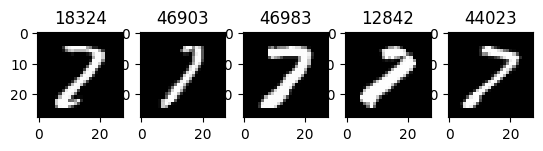

In [15]:
def show_images(indices, num):
    ''' show an image with matplotlib '''
    fig, axs = plt.subplots(1, num);
    imgs = []
    for i in range(num):
      imgs.append(train_set[indices[i]][0].numpy().reshape(28, 28))
    for i in range(num):
      axs[i].imshow(imgs[i], cmap='gray')
      axs[i].set_title(str(indices[i]))

show_images(list(top_influential_dict.keys()), 5) # 0.065

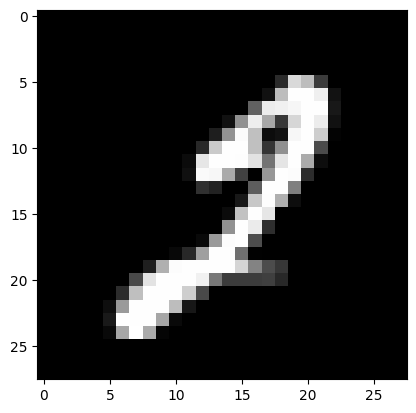

In [14]:
show_image(32951)

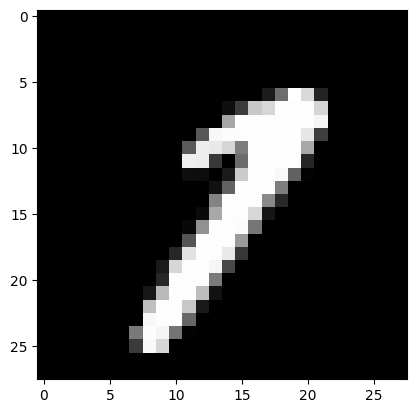

In [ ]:
show_image(10067)

In [16]:
def retrain_until_convergence(model, train_dataloader, loss_fn,
                              optimizer, input=None, label=None, old_loss=None,
                              threshold=0.001, max_epochs=100):
  torch.manual_seed(42)
  random.seed(42)
  np.random.seed(42)

  train_losses = []

  prev_epoch_loss = float('inf')
  patience = 0

  for epoch in range(max_epochs):
    model.train()
    # train_dataloader epoch
    current_epoch_loss = 0.0
    for data, target in train_dataloader:
      optimizer.zero_grad()
      output = model(data)
      loss = loss_fn(output, target)
      current_epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
    train_losses.append(current_epoch_loss / len(train_dataloader))
    print(f"Epoch {epoch+1}/{max_epochs}, Loss: {current_epoch_loss / len(train_dataloader)}")

    with torch.no_grad():
      model.eval()
      output = model(input)
      new_loss = loss_fn(output, torch.tensor([label], dtype=torch.long))
      print(f"New loss - old loss: {new_loss.item() - old_loss}")

    # # early stopping
    # if abs(prev_epoch_loss - current_epoch_loss) < threshold:
    #   patience += 1
    # else:
    #   patience = 0
    # prev_epoch_loss = current_epoch_loss
    # if patience == 5:
    #   break

  return train_losses

In [17]:
def verify_influence_score(idx):
  torch.manual_seed(42)
  np.random.seed(42)
  random.seed(42)

  model.eval()
  loss_fn = nn.CrossEntropyLoss()
  initial_loss = loss_fn(model(z_input), torch.tensor([z_label])).item()

  new_model = LogReg()
  new_model.load_state_dict(torch.load('init_model_weights.pth'))
  new_model.eval()

  new_subset = Subset(train_set, [i for i in range(len(train_set)) if i != idx])
  new_loader = DataLoader(new_subset, batch_size=1400, shuffle=False)
  new_optimizer = optim.SGD(new_model.parameters(), lr=0.01, weight_decay=0.01)

  train_losses = retrain_until_convergence(new_model, new_loader, loss_fn,
                            new_optimizer, input=z_input, label=z_label,
                            old_loss=initial_loss)

  new_loss = loss_fn(new_model(z_input), torch.tensor([z_label])).item()

  return (new_loss - initial_loss), train_losses, new_model

In [62]:
def retrain_all():
  torch.manual_seed(42)
  np.random.seed(42)
  random.seed(42)

  model.eval()

  actual_diffs = {}
  for (idx, if_score) in top_influential_dict.items():
    print("idx: " + str(idx))
    print("if_score: " + str(if_score))
    if idx == 18324 or idx == 46903:
      continue
    diff, losses, nm = verify_influence_score(idx)
    actual_diffs[idx] = diff
  return actual_diffs

In [63]:
actual_diffs = retrain_all()

idx: 18324
if_score: -3332.79833984375
idx: 46903
if_score: -2877.99853515625
idx: 46983
if_score: -2873.382080078125


<ipython-input-17-b8746d33162d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('init_model_weights.pth'))


Epoch 1/100, Loss: 1.3164348751306534
New loss - old loss: -1.6148831844329834
Epoch 2/100, Loss: 0.7387487441301346
New loss - old loss: -1.186619520187378
Epoch 3/100, Loss: 0.6017027959227562
New loss - old loss: -0.9698996543884277
Epoch 4/100, Loss: 0.5364012017846107
New loss - old loss: -0.8361132144927979
Epoch 5/100, Loss: 0.49696444198489187
New loss - old loss: -0.7422816753387451
Epoch 6/100, Loss: 0.4700532019138336
New loss - old loss: -0.6706805229187012
Epoch 7/100, Loss: 0.45026116371154784
New loss - old loss: -0.6128373146057129
Epoch 8/100, Loss: 0.43494822457432747
New loss - old loss: -0.564239501953125
Epoch 9/100, Loss: 0.4226590894162655
New loss - old loss: -0.5222725868225098
Epoch 10/100, Loss: 0.41252007856965067
New loss - old loss: -0.48531436920166016
Epoch 11/100, Loss: 0.40397211611270906
New loss - old loss: -0.4522991180419922
Epoch 12/100, Loss: 0.39663939327001574
New loss - old loss: -0.42249011993408203
Epoch 13/100, Loss: 0.3902590908110142
New 

In [64]:
print(actual_diffs)

{46983: 0.05930471420288086, 12842: 0.03374767303466797, 44023: 0.05176830291748047, 48353: 0.0441279411315918, 13741: 0.041916847229003906, 45031: 0.017226696014404297, 20525: 0.04685163497924805, 41639: 0.027144432067871094, 25230: 0.039620399475097656, 47233: 0.0398402214050293}


In [69]:
actual_diffs[32951] = -0.0291748046875
actual_diffs[10067] = -0.011373043060302734
actual_diffs[18324] = 0.06061983108520508
actual_diffs[46903] = 0.057385921478271484

In [70]:
print(actual_diffs)

{46983: 0.05930471420288086, 12842: 0.03374767303466797, 44023: 0.05176830291748047, 48353: 0.0441279411315918, 13741: 0.041916847229003906, 45031: 0.017226696014404297, 20525: 0.04685163497924805, 41639: 0.027144432067871094, 25230: 0.039620399475097656, 47233: 0.0398402214050293, 32951: -0.0291748046875, 10067: -0.011373043060302734, 18324: 0.06061983108520508, 46903: 0.057385921478271484}


In [71]:
actual_vals = []
expected_vals = []
for (idx, diff) in actual_diffs.items():
  actual_vals.append(diff)
  expected_vals.append( (-1.0/55000) * influence_scores[idx])

In [72]:
print(actual_vals)
print(expected_vals)

[0.05930471420288086, 0.03374767303466797, 0.05176830291748047, 0.0441279411315918, 0.041916847229003906, 0.017226696014404297, 0.04685163497924805, 0.027144432067871094, 0.039620399475097656, 0.0398402214050293, -0.0291748046875, -0.011373043060302734, 0.06061983108520508, 0.057385921478271484]
[0.052243310546875, 0.05066813742897727, 0.04775015536221591, 0.04765867365056818, 0.04756106178977273, 0.041406818181818184, 0.0404953125, 0.040247829367897725, 0.039089293323863634, 0.038173117897727274, -0.028615804776278408, -0.031870596590909094, 0.060596333451704544, 0.05232724609375]


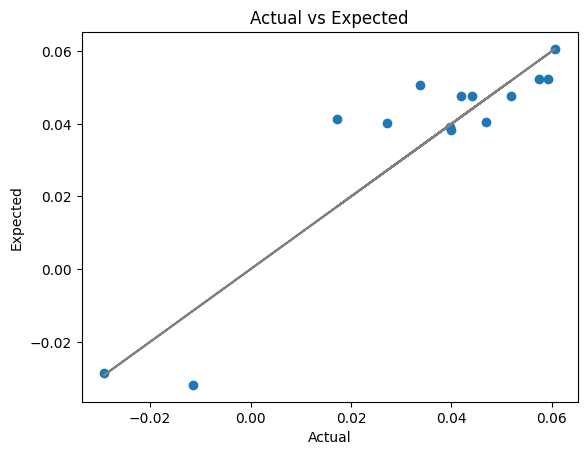

In [74]:
plt.scatter(actual_vals, expected_vals)
plt.plot(actual_vals, 1*np.array(actual_vals) + 0, color='gray')
plt.xlabel('Actual')
plt.ylabel('Expected')
plt.title('Actual vs Expected')
plt.show()

In [75]:
correlation = np.corrcoef(actual_vals, expected_vals)[0, 1]
print(correlation)

0.9206939643060056


In [18]:
diff, losses, new_model = verify_influence_score(32951)

<ipython-input-17-b8746d33162d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('init_model_weights.pth'))


Epoch 1/100, Loss: 1.316452232003212
New loss - old loss: -1.6183829307556152
Epoch 2/100, Loss: 0.7387766927480698
New loss - old loss: -1.1931731700897217
Epoch 3/100, Loss: 0.6017288073897362
New loss - old loss: -0.9792468547821045
Epoch 4/100, Loss: 0.5364239290356636
New loss - old loss: -0.8480644226074219
Epoch 5/100, Loss: 0.49698377400636673
New loss - old loss: -0.7566778659820557
Epoch 6/100, Loss: 0.470069270581007
New loss - old loss: -0.6873817443847656
Epoch 7/100, Loss: 0.4502741776406765
New loss - old loss: -0.631718635559082
Epoch 8/100, Loss: 0.4349583834409714
New loss - old loss: -0.5851902961730957
Epoch 9/100, Loss: 0.4226665996015072
New loss - old loss: -0.5451927185058594
Epoch 10/100, Loss: 0.4125251032412052
New loss - old loss: -0.5101132392883301
Epoch 11/100, Loss: 0.40397482365369797
New loss - old loss: -0.4788951873779297
Epoch 12/100, Loss: 0.3966399319469929
New loss - old loss: -0.4508085250854492
Epoch 13/100, Loss: 0.39025759771466256
New loss -

In [ ]:
diff, losses, new_model = verify_influence_score(10067)

<ipython-input-19-b8746d33162d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('init_model_weights.pth'))


Epoch 1/100, Loss: 1.3164558678865432
New loss - old loss: -1.617924690246582
Epoch 2/100, Loss: 0.738789938390255
New loss - old loss: -1.1921865940093994
Epoch 3/100, Loss: 0.6017470329999923
New loss - old loss: -0.9777898788452148
Epoch 4/100, Loss: 0.5364457026124001
New loss - old loss: -0.8461942672729492
Epoch 5/100, Loss: 0.49700822681188583
New loss - old loss: -0.7544407844543457
Epoch 6/100, Loss: 0.4700958475470543
New loss - old loss: -0.6848137378692627
Epoch 7/100, Loss: 0.4503024876117706
New loss - old loss: -0.6288466453552246
Epoch 8/100, Loss: 0.43498816415667535
New loss - old loss: -0.5820331573486328
Epoch 9/100, Loss: 0.422697651386261
New loss - old loss: -0.5417661666870117
Epoch 10/100, Loss: 0.4125572592020035
New loss - old loss: -0.5064277648925781
Epoch 11/100, Loss: 0.40400796830654145
New loss - old loss: -0.4749579429626465
Epoch 12/100, Loss: 0.39667396917939185
New loss - old loss: -0.4466261863708496
Epoch 13/100, Loss: 0.39029242247343066
New loss

In [ ]:
diff, losses, new_model = verify_influence_score(18324)

<ipython-input-81-b8746d33162d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('init_model_weights.pth'))


Epoch 1/100, Loss: 1.3164239764213561
New loss - old loss: -1.6156885623931885
Epoch 2/100, Loss: 0.7387327939271927
New loss - old loss: -1.1874463558197021
Epoch 3/100, Loss: 0.6016830071806908
New loss - old loss: -0.9705841541290283
Epoch 4/100, Loss: 0.5363791555166244
New loss - old loss: -0.8366091251373291
Epoch 5/100, Loss: 0.4969407871365547
New loss - old loss: -0.74257493019104
Epoch 6/100, Loss: 0.4700282171368599
New loss - old loss: -0.6707682609558105
Epoch 7/100, Loss: 0.45023502707481383
New loss - old loss: -0.6127195358276367
Epoch 8/100, Loss: 0.43492103591561315
New loss - old loss: -0.5639214515686035
Epoch 9/100, Loss: 0.4226309396326542
New loss - old loss: -0.5217604637145996
Epoch 10/100, Loss: 0.412490988522768
New loss - old loss: -0.4846158027648926
Epoch 11/100, Loss: 0.4039421483874321
New loss - old loss: -0.45142173767089844
Epoch 12/100, Loss: 0.39660858139395716
New loss - old loss: -0.42144203186035156
Epoch 13/100, Loss: 0.390227472037077
New loss 

In [19]:
diff2, losses2, new_model2 = verify_influence_score(46903)

<ipython-input-17-b8746d33162d>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load('init_model_weights.pth'))


Epoch 1/100, Loss: 1.3164319694042206
New loss - old loss: -1.6150145530700684
Epoch 2/100, Loss: 0.7387519523501396
New loss - old loss: -1.1868529319763184
Epoch 3/100, Loss: 0.6017083123326301
New loss - old loss: -0.9701969623565674
Epoch 4/100, Loss: 0.5364076167345047
New loss - old loss: -0.8364522457122803
Epoch 5/100, Loss: 0.49697117805480956
New loss - old loss: -0.7426474094390869
Epoch 6/100, Loss: 0.4700599186122417
New loss - old loss: -0.6710610389709473
Epoch 7/100, Loss: 0.4502676747739315
New loss - old loss: -0.613224983215332
Epoch 8/100, Loss: 0.43495440408587455
New loss - old loss: -0.5646281242370605
Epoch 9/100, Loss: 0.42266486659646035
New loss - old loss: -0.5226588249206543
Epoch 10/100, Loss: 0.4125253662467003
New loss - old loss: -0.48569583892822266
Epoch 11/100, Loss: 0.4039768859744072
New loss - old loss: -0.45267438888549805
Epoch 12/100, Loss: 0.39664361625909805
New loss - old loss: -0.42285966873168945
Epoch 13/100, Loss: 0.3902627624571323
New 